    AUTHOR : Mikael Frenette
    
    IN THIS TUTORIAL, I WILL INTRODUCE THE BASIC USAGE OF THE MODEL PROPOSED
    IN THE PAPER "From Reactive to Proactive Volatility Modeling with
    Hemisphere Neural Networks" by Philippe Goulet Coulombe, Mikael Frenette
    and Karin Klieber (2023).

    TO SEE IMPLEMENTATION SOURCE CODE, PLEASE SEE THE GITHUB :
    https://github.com/TheAionxGit/Aionx

    FOR ANY QUESTION PLEASE COMMUNICATE WITH ME:
     - Mikael Frenette (mik.frenette@gmail.com)

In [1]:
!pip install arch aionx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

tf.data.experimental.enable_debug_mode()
gpus = tf.config.list_physical_devices(device_type = 'GPU')
if gpus:
    print(gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True) # let tensorflow control GPU memory usage
else:
    print("No GPU detected.")


from sklearn.linear_model import LinearRegression
from arch import arch_model
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import FormatStrFormatter

from keras.initializers import RandomNormal
from keras.layers import Flatten, Dense, Input, Dropout
from keras.models import Sequential, Model

from aionx.pipelines import RegressionMatrix
from aionx.kerasnn.ensemble import DeepEnsemble, OutOfBagPredictor
from aionx.utils import add_trends
from aionx.scalers import StandardScaler
from aionx.bootstrap import TimeSeriesBlockBootstrap
from aionx.pipelines import WindowDataset
from aionx.kerasnn.trainers import Trainer
from aionx.utils import add_trends

from aionx.metrics import RootMeanSquaredError, NominalCoverage, LogScore

No GPU detected.


In [4]:
# **NOTE :
# - DeepEnsemble class is designed in a way that it can be run in graph mode.
# - For more information about properties of graph mode, please read tensorflow's documentations:
# - https://www.tensorflow.org/guide/intro_to_graphs

# - by default graph mode is enabled. This will significantly increase the training speed of
#   neural networks.

# - If one wishes to run the model in eager mode or if the function is causing
#   operation issues, graph mode can be disabled by setting :

#   tf.config.run_functions_eagerly(True)

tf.config.run_functions_eagerly(False)

In [5]:
# import data
data = pd.read_csv(
    "https://raw.githubusercontent.com/TheAionxGit/Aionx/main/datasets/FREDQD.csv", index_col=0)
data.index = pd.to_datetime(data.index)

In [6]:
# CONSTANTS

TARGET = "GDPC1" # must be a column name in data
TRAIN_START = "1960-01-01"
TRAIN_END   = "2006-12-01"
TEST_START  = "2007-01-01"
TEST_END    = "2022-12-01"
TRENDS = 100
LAGS = 2
S = 1 # number of steps in the future to forecast
SAMPLING_RATE = 0.8
BLOCK_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 1e-3
BOOTSTRAPS = 200
PATIENCE = 15 # patience for earlystopping

In [7]:
####
# We add trends to the dataset. One can safely remove them by setting trends=0
###
data_with_trends = add_trends(data, trends = TRENDS)

In [8]:

# computes mean/std on the train period then scales the entire data
scaler = StandardScaler()
scaler.get_stats( data_with_trends.loc[TRAIN_START:TRAIN_END] )
data_scaled = scaler.scale(data_with_trends)

# keep train
train_scaled = data_scaled.loc[TRAIN_START:TRAIN_END, :]

In [9]:
pipeline = WindowDataset(in_steps=LAGS, horizon=S, targets=[TARGET])
pipeline

Total window size: 3
Input indices: [0, 1]
Label indices: [2]
Label column name(s): ['GDPC1']

In [10]:
####
# In the paper we used 3D inputs (batch, lags, features) because we also used an LSTM.
# For regular Dense networks, one can use a 2D input matrix (batch, lags*features)
####
X_train, y_train = pipeline(train_scaled)
X_train.shape, y_train.shape

((180, 2, 344), (180, 1, 1))

In [11]:
#####
# TimeSeriesBlockBootstrap is a python generator. it generates bootstraps as follow:
# xboot, yboot, xoob, yoob = next(sampler)
####
sampler = TimeSeriesBlockBootstrap(
    X=X_train, y=y_train,
    sampling_rate=SAMPLING_RATE,
    block_size=BLOCK_SIZE,
    replace=True
)


In [12]:
class GaussianLogLikelihood(tf.keras.losses.Loss):
    """
    This is the loss function used in the paper
    """
    def __init__(self, volatility_clip:float=0.05, **kwargs):
        super().__init__(**kwargs)
        self.clip = volatility_clip

    @tf.function
    def call(self, y_true, y_pred):
        mu, sigma = tf.split(y_pred,
                             num_or_size_splits=2,
                             axis=-1)

        mu    = tf.squeeze(mu)
        sigma = tf.squeeze(sigma)
        y     = tf.squeeze(y_true)
        # Squeeze the tensors to remove any extra dimensions.

        # Clip the volatility to stabilize loss
        sigma = tf.where(sigma > self.clip, sigma, self.clip)

        # Compute the loss using the log-likelihood of the normal distribution.
        loss = tf.reduce_mean(
            tf.math.square(y - mu) / tf.math.square(sigma) + tf.math.log(tf.math.square(sigma))
            )
        #loss = -tf.reduce_sum(tfp.distributions.Normal(loc=μ, scale=σ).log_prob(y))
        return loss

# The Network

## Ingredient 1 & 2 - hemispheres & volatility emphasis
<br>
- in the paper we compute the volatility emphasis parameter by using the mean squared error of the out-of-bag predictions of a regular neural network. In this tutorial, we will manually set its value so one can experiment with it. Feel free to use another model to estimate it.

In [13]:
#####
# be careful to set the value between 0.01 and 0.99.
# helper : {inflation:0.25, GDP:0.72, S&P 500:0.99}
#####
VOL_EMPHASIS = 0.72

In [14]:
####
# we can create the network with keras by using both the sequential API to create the hemispheres
# and the functional API to put them together. Feel free to experiment with other parameters.
####
inputs = Input(shape=(X_train.shape[1:]))

shared_hemisphere = Sequential([
    Flatten(),
    Dense(units=400,
        activation="relu",
        kernel_initializer=RandomNormal(mean=0, stddev=0.03),
        ),
    Dropout(0.2),
    Dense(units=400,
        activation="relu",
        kernel_initializer=RandomNormal(mean=0, stddev=0.03),
        ),
    keras.layers.Dropout(0.2),
], name="shared_hemisphere")

mean_hemisphere = Sequential([
    Dense(units=400,
        activation="relu",
        kernel_initializer=RandomNormal(mean=0, stddev=0.03),
        ),
    Dropout(0.2),
    Dense(units=400,
        activation="relu",
        kernel_initializer=RandomNormal(mean=0, stddev=0.03),
        ),
    Dropout(0.2),
    Dense(1, activation='linear'),
], name="conditional_mean_hemisphere")

vol_hemisphere = Sequential([
    Dense(units=400,
        activation="relu",
        kernel_initializer=RandomNormal(mean=0, stddev=0.03),
        ),
    Dropout(0.2),
    Dense(units=400,
        activation="relu",
        kernel_initializer=RandomNormal(mean=0, stddev=0.03),
        ),
    Dropout(0.2),
    Dense(1, activation='softplus'),
], name="conditional_vol_hemisphere")

z = shared_hemisphere(inputs)
mean_output = mean_hemisphere(z)
vol_output = vol_hemisphere(z)

vol_output = tf.math.scalar_mul(
    VOL_EMPHASIS,
    tf.math.divide(vol_output, tf.reduce_mean(vol_output)) # force volatility to 1.0
    ) # mean volatility output becomes 1.0 * vol_emphasis

output = tf.concat([mean_output, vol_output], axis=-1)

HNN = Model(inputs=[inputs], outputs=[output], name="density_hnn")



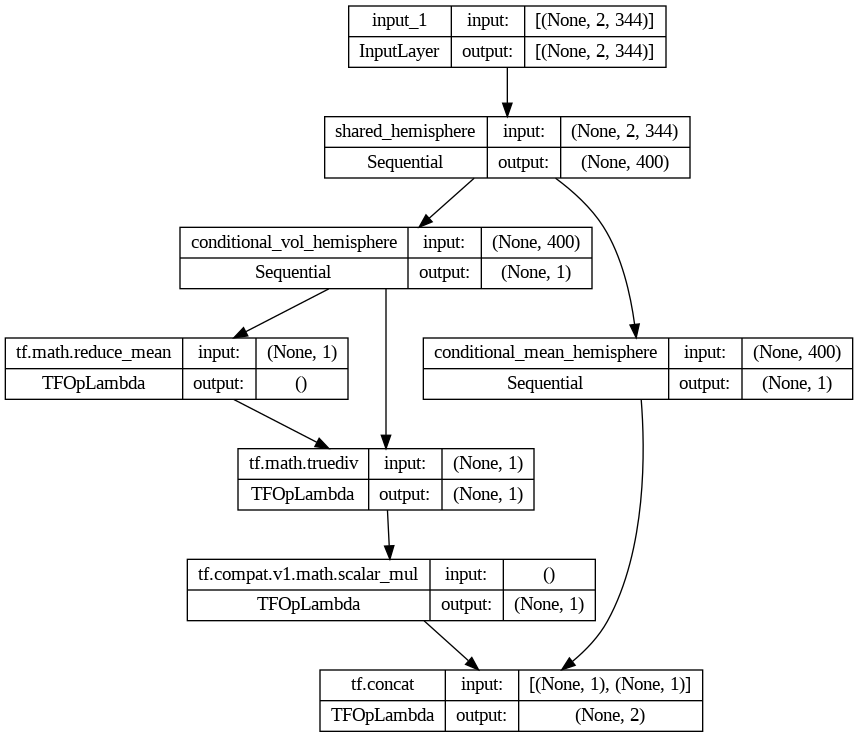

In [33]:
keras.utils.plot_model(HNN, show_shapes=True)

## Ingredient 3 - Bagging
<br>
- One of the core ingredients of the model is bootstrap aggregating. Each estimator is fitted on a subsample of the training set. Then, we average out the predictions to obtain a forecast.

In [15]:
####
# Using a Trainer object is not mandatory. if not provided, make sure to compile the model.
# model.compile(loss=..., optimizer=....)
####
trainer = Trainer(loss=GaussianLogLikelihood(), optimizer=keras.optimizers.Adam(LEARNING_RATE))
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE)

In [16]:
####
# The model is not designed to use batches during training and inference.
####
model = DeepEnsemble(n_estimators=BOOTSTRAPS, network=HNN, trainer=trainer, sampler = sampler)

model.fit(X_train, y_train, epochs=EPOCHS, early_stopping=es,
          batch_size=None, validation_batch_size=None, verbose=2)

density_hnn [200/200] |█████---------------| Step: 1/1 | Epoch: 21/100 (21%) | loss: -0.5968 | val_loss: 2.8404 completed in 00:07:30


In [17]:
####
# to obtain the out-of_sample forecast we can force the pipeline to not generate y_{t+s}.
# This way, we get the inputs needed to predict values not available in the dataset.
####
pred_pipeline = WindowDataset(in_steps=LAGS, horizon=0, out_steps=0, targets=[TARGET])
X_full, _ = pred_pipeline(data_scaled)

In [18]:
####
# model.predict will output the estimators forecast. That is, a matrix (N, n_estimators).
# One for the conditional mean and one for the conditional volatility.
# When using .predict(), we must force the model to use the entire sample. batch_size = all Xs
####
mean_preds, vol_preds = model.predict(
    X_full, batch_size=X_full.shape[0], verbose=0
)

In [19]:
mean_preds.shape, vol_preds.shape

((245, 200), (245, 200))

In [20]:
pred_idx = pd.date_range(
    data.index[0+LAGS+S-1],
    periods=len(data)-LAGS+1,
    freq=pd.infer_freq(data.index)
)

In [21]:
####
# This is not necessary if one is not interested in the out-of-bag prediction.
####
oob_predictor = OutOfBagPredictor(model.oob_indices)

hnn_mean_oob = oob_predictor(
    np.copy(mean_preds[:len(y_train)]), sampling_rate=SAMPLING_RATE
)
hnn_mean_oos = np.mean(np.copy(mean_preds[len(y_train):]), axis=-1)
hnn_mean = np.concatenate([hnn_mean_oob, hnn_mean_oos], axis=0)
hnn_mean_unscaled = scaler.unscale(
    pd.DataFrame(hnn_mean, columns=["conditional_mean"], index=pred_idx),
    TARGET, use_mean=True
)

hnn_vol_oob = oob_predictor(
    np.copy(vol_preds[:len(y_train)]), sampling_rate=SAMPLING_RATE
)
hnn_vol_oos = np.mean(np.copy(vol_preds[len(y_train):]), axis=-1)
hnn_vol = np.concatenate([hnn_vol_oob, hnn_vol_oos], axis=0)
hnn_vol_unscaled = scaler.unscale(
    pd.DataFrame(hnn_vol, columns=["conditional_volatility"], index=pred_idx),
    TARGET, use_mean=True
)

In [22]:
hnn_forecast = pd.concat([hnn_mean_unscaled, hnn_vol_unscaled], axis=1)

## Ingredient 4 - Volatility rescaling
<br>
- Unfortunately, neural networks tend to produce overconfident predictions. That is, it tends to make wrong predictions with a high level of confidence. In practice, this means that the volatility tends to vanish or becomes very small. To do so, we need to recalibrate the volatility. See the paper for more details.

In [23]:
def volatility_rescaling_algorithm(y_true:pd.Series,
                                 y_pred:pd.Series,
                                 vol_pred:pd.Series,
                                 oob_start:str,
                                 oob_end:str)->pd.Series:
    """
    PARAMETERS
    ----------
    y_true    : the true values of the target variable.

    y_pred    : the ensemble prediction of the conditional mean.
                predictions on the training set must be out-of-bag.

    vol_pred  : the ensemble prediction conditional volatility.
                predictions on the training set must be out-of-bag.

    oob_start : the start index of the out-of-bag (OOB) samples.

    oob_end   : the end index of the out-of-bag (OOB) samples.

    RETURNS
        VolatilityRescaled : the rescaled predicted volatility.

    """

    # concatenate the true and predicted values
    merged = pd.concat([y_true, y_pred], axis=1).dropna()

    # calculate the model residuals
    HNN_residuals = merged.iloc[:, 0] - merged.iloc[:, 1]

    # concatenate the squared residuals and estimated volatility squared,
    # and only keep the
    # forecast on the train set (i.e., OOB)
    merged_oob = pd.concat([HNN_residuals**2,
                            vol_pred**2], axis=1).loc[oob_start:oob_end]

    # use the squared estimated volatility as the input (X) for the
    # linear regression
    X_train = merged_oob.iloc[:, 1].values.reshape(-1, 1)

    # use the squared residuals as the output (y) for the linear regression
    y_train = merged_oob.iloc[:, 0].values.reshape(-1, 1)

    # create a linear regression object and fit the training data
    linreg = LinearRegression()
    linreg.fit(np.log(X_train), np.log(y_train))

    # use the full predicted volatility as the input for the linear
    # regression
    full_X = np.log(vol_pred**2)

    # predict the log of the residuals based on the log of the estimated
    # volatility
    projection = linreg.predict(full_X.values.reshape(-1, 1))

    # store the predictions in a dataframe
    pred = pd.DataFrame(projection, columns=["vol"], index=y_pred.index)

    # merge the log squared errors of the model and the predictions and
    # drop any missing data
    merged2 = pd.concat([np.log(merged_oob.iloc[:, 0]), pred],
                        axis=1).dropna()

    # calculate the residuals between the two merged dataframes
    res = merged2.iloc[:, 0].values - merged2.iloc[:, 1].values

    # calculate the scaler by taking the square root of the mean
    # exponential of the residuals
    scaler = np.sqrt(np.mean(np.exp(res)))

    # adjust the predicted volatility based on the scaler
    VolatilityRescaled = np.sqrt(np.exp(pred)) * scaler

    return VolatilityRescaled

In [24]:
hnn_forecast["conditional_volatility"] = volatility_rescaling_algorithm(
                                y_true    = data[TARGET],
                                y_pred    = hnn_forecast["conditional_mean"],
                                vol_pred  = hnn_forecast["conditional_volatility"],
                                oob_start = TRAIN_START,
                                oob_end   = TRAIN_END
)

In [25]:
####
# for convenience, we use Aionx metrics. though one can use functions provided by other libraries.
####
RMSE       = RootMeanSquaredError()
Score      = LogScore()
Coverage68 = NominalCoverage(std=1)
Coverage95 = NominalCoverage(std=2)

In [26]:
####
# For simplicity, we use GARCH as benchmark. To evaluate the RMSE of both HNN and GARCH,
# we will divide it by the one from an AR(p)
####

# will store metrics here
bench_results = pd.DataFrame()

matrix_generator = RegressionMatrix(targets=[TARGET], in_steps=LAGS, horizon=S)
matrix = matrix_generator(data[[TARGET]], return_dataframe=True).dropna()

# set training inputs
X_train = matrix.loc[TRAIN_START:TRAIN_END, :].drop(TARGET, axis=1)
y_train = matrix.loc[TRAIN_START:TRAIN_END, TARGET]

# create linear regression model
model = LinearRegression()
model.fit(X_train, y_train) # fit the model

# create forecasted indexes
fcst_index = pd.date_range(matrix.index[0],
                           periods=len(matrix),
                           freq=pd.infer_freq(data.index))

AR = pd.DataFrame(
    model.predict(matrix.iloc[:, 1:]), columns=[TARGET], index=fcst_index
)

# align and remove N/A values
merged = pd.concat([matrix[TARGET], AR[TARGET]], axis=1)

# I compute now some necessary metrics from the benchmarks
# by setting squared to false, we get the RMSE.
AR2_train_mse = RMSE(
    merged.loc[TRAIN_START:TRAIN_END].iloc[:, 0],
    merged.loc[TRAIN_START:TRAIN_END].iloc[:, 1]
)
AR2_test1_mse = RMSE(
    merged.loc[TEST_START:"2020-01-01"].iloc[:, 0],
    merged.loc[TEST_START:"2020-01-01"].iloc[:, 1]
)
AR2_test2_mse = RMSE(
    merged.loc[TEST_START:TEST_END].iloc[:, 0],
    merged.loc[TEST_START:TEST_END].iloc[:, 1]
)

# store metrics in a dataframe
bench_results.loc["train set", f"{TARGET}_h{1}"]  = AR2_train_mse
bench_results.loc["val set", f"{TARGET}_h{1}"]  = AR2_test1_mse
bench_results.loc["test set", f"{TARGET}_h{1}"] = AR2_test2_mse

# fit a garch model
garch = arch_model(y=data[TARGET], mean="AR", p=1, q=1, vol = 'GARCH', lags=LAGS,
                            dist = 'normal').fit(disp=False, last_obs=TRAIN_END,
                                                 options={"maxiter":10000,
                                                                "ftol":1e-5,
                                                                "eps":1e-4})

# produce forecast with the garch model
fc = garch.forecast(horizon=1, start = data.index[0+LAGS], align="target")

# keep and transform what is needed.
AR_Garch = pd.DataFrame({
  "mean":fc.mean.iloc[:, -1].squeeze(),
  "volatility":np.sqrt(fc.variance.iloc[:, -1].squeeze())
}, index=fc.mean.index).dropna()


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.067e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<ipython-input-27-41ef30dd654c>:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  legend = fig.legend([target_ax, mean_ax, garch_ax],


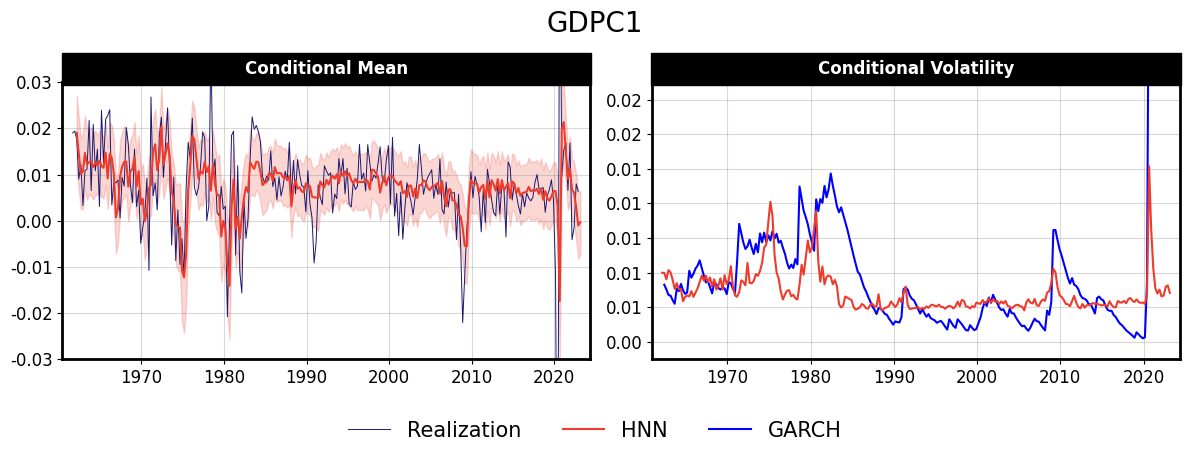

In [27]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2.0

# plot size
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols =2, figsize=(12, 4))
fig.suptitle(f"{TARGET}", size=20)

target_ax = ax0.plot(data[TARGET], color="midnightblue", linewidth=.7)[0]
mean_ax   = ax0.plot(hnn_forecast[f"conditional_mean"], color="#ef3b2c")[0]
garch_ax  = ax1.plot(AR_Garch["volatility"], color="blue")[0]
vol_ax  = ax1.plot(hnn_forecast[f"conditional_volatility"], color="#ef3b2c")


legend = fig.legend([target_ax, mean_ax, garch_ax],
           labels=[f"Realization", "HNN", "GARCH"],
            loc='upper center', bbox_to_anchor=(0.5, -0.00),
                  fancybox=False, shadow=False, ncol=5, frameon=False,
                  fontsize=10,  prop={"size":15})

ax0.fill_between(hnn_forecast.index,
                     hnn_forecast[f"conditional_mean"].squeeze()- hnn_forecast[f"conditional_volatility"].squeeze(), # lower bound
                     hnn_forecast[f"conditional_mean"].squeeze() + hnn_forecast[f"conditional_volatility"].squeeze(), # upper bound
                     color="#ef3b2c", alpha=.2)

title1 = ax0.set_title("Conditional Mean",  backgroundcolor='black', color='white',
                      fontweight="bold",
                size=12, position=(.5, 1.01))
title1._bbox_patch._mutation_aspect = 0.04
title1.get_bbox_patch().set_boxstyle("square", pad=11)

ax0.tick_params(axis="both", labelsize=12)
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax0.grid(color='grey', alpha=.3)
ax0.margins(x=0.02)
ax0.margins(y=0.02)

if TARGET == "GDPC1":
    ax0.set_ylim((-0.03, 0.03))
    ax1.set_ylim((0.003, .019))

title1 = ax1.set_title("Conditional Volatility",  backgroundcolor='black', color='white',
                      fontweight="bold",
                size=12, position=(.5, 1.01))
title1._bbox_patch._mutation_aspect = 0.04
title1.get_bbox_patch().set_boxstyle("square", pad=10)

ax1.tick_params(axis="both", labelsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.grid(color='grey', alpha=.3)
ax1.margins(x=0.02)
ax1.margins(y=0.02)

plt.tight_layout()
plt.show()

In [28]:
metrics = pd.DataFrame()
model_dict = {"HNN":hnn_forecast, "GARCH":AR_Garch}
# calcule des rmses qu'on divise par l'indice de référence (les AR(2))
for model, fcst in model_dict.items():
    merged = pd.concat([
        data[TARGET],
        fcst
    ], axis=1).dropna()

    merged.columns = [TARGET, "mean", "vol"]

    train_RMSE = RMSE(
        merged.iloc[:, 0].loc[TRAIN_START:TRAIN_END],
        merged.iloc[:, 1].loc[TRAIN_START:TRAIN_END]
    ) / AR2_train_mse

    test1_RMSE = RMSE(
        merged.iloc[:, 0].loc[TEST_START:"2020-01-01"],
        merged.iloc[:, 1].loc[TEST_START:"2020-01-01"]
    ) / AR2_test1_mse

    test2_RMSE = RMSE(
        merged.iloc[:, 0].loc[TEST_START:TEST_END],
        merged.iloc[:, 1].loc[TEST_START:TEST_END]
    ) / AR2_test2_mse

    train_score = Score(
        merged.loc[TRAIN_START:TRAIN_END, [TARGET]],
        merged.loc[TRAIN_START:TRAIN_END, ["mean", "vol"]]
    )

    test1_score = Score(
        merged.loc[TEST_START:"2020-01-01", TARGET],
        merged.loc[TEST_START:"2020-01-01", ["mean", "vol"]]
    )

    test2_score = Score(
        merged.loc[TEST_START:TEST_END, TARGET],
        merged.loc[TEST_START:TEST_END, ["mean", "vol"]]
    )

    train_cov68 = Coverage68(
        y_true=merged.loc[TRAIN_START:TRAIN_END, TARGET],
        y_pred=merged.loc[TRAIN_START:TRAIN_END, ["mean", "vol"]]
    )

    test1_cov68 = Coverage68(
        y_true=merged.loc[TEST_START:"2020-01-01", TARGET],
        y_pred=merged.loc[TEST_START:"2020-01-01", ["mean", "vol"]]
    )

    test2_cov68 = Coverage68(
        y_true=merged.loc[TEST_START:TEST_END, TARGET],
        y_pred=merged.loc[TEST_START:TEST_END, ["mean", "vol"]]
    )


    train_cov95 = Coverage95(
        y_true=merged.loc[TRAIN_START:TRAIN_END, TARGET],
        y_pred=merged.loc[TRAIN_START:TRAIN_END, ["mean", "vol"]]
    )

    test1_cov95 = Coverage95(
        y_true=merged.loc[TEST_START:"2020-01-01", TARGET],
        y_pred=merged.loc[TEST_START:"2020-01-01", ["mean", "vol"]]
    )

    test2_cov95 = Coverage95(
        y_true=merged.loc[TEST_START:TEST_END, TARGET],
        y_pred=merged.loc[TEST_START:TEST_END, ["mean", "vol"]]
    )


    metrics.loc["RMSE(oob)", model] = train_RMSE
    metrics.loc["RMSE < 2020", model]   = test1_RMSE
    metrics.loc["RMSE", model]  = test2_RMSE
    metrics.loc["Score(oob)", model] = train_score
    metrics.loc["Score < 2020", model]   = test1_score
    metrics.loc["Score", model]  = test2_score

    metrics.loc["coverage 68% oob", model] = train_cov68
    metrics.loc["coverage 68% < 2020", model] = test1_cov68
    metrics.loc["coverage 68% Test set", model] = test2_cov68
    metrics.loc["coverage 95% oob", model] = train_cov95
    metrics.loc["coverage 95% < 2020", model] = test1_cov95
    metrics.loc["coverage 95% Test set", model] = test2_cov95

metrics


,HNN,GARCH
RMSE(oob),0.894739,1.001830
RMSE < 2020,0.807492,1.007345
RMSE,0.986418,1.001418
Score(oob),-3.566240,-3.521348
Score < 2020,-3.880454,-3.716284
Score,-1.974593,-2.114506
coverage 68% oob,0.677778,0.709497
coverage 68% < 2020,0.903846,0.846154
coverage 68% Test set,0.828125,0.828125
coverage 95% oob,0.966667,0.966480
